# Implicit Filter on the DKRZ GPU

## Imports

In [1]:
from implicit_filter import CuPyFilter 
import math
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from implicit_filter import convert_to_wavenumbers

## Parameters

In [2]:
coord_path = "/work/bb1474/a270133/meshes/orca25/orca25_griddes_nodes.nc"
meshdiag_path = "/work/bb1474/a270133/meshes/orca25/fesom.mesh.diag.nc"
data_path = "/work/bb1474/a270133/runtime/fesom-2.6/orca25-reference-no_visc_bsreturn-historic/outdata/fesom/ssh.fesom.195901.01.nc"

nfilter = 100  # number of filter runs

distance = 1_000 # filter size
dxm = 5 # mesh resolution
wavelength = 70

## Fix preparation function for newer (?) fesom output version

The format of our diag files seems to differ, so we need an own preparation function:

In [3]:
def prepare_from_file(flter, file_md: str, file_crd: str, meshtype: str = 'r', carthesian: bool = False,
                          cyclic_length: float = 360.0 * math.pi / 180.0, metric: bool = False):
        """
        Prepare the filter to be used with a mesh provided in the given file path.

        Parameters:
        -----------
        file : str
            Path to the FESOM mesh file.

        meshtype : str
        Mesh type, either 'm' (metric) or 'r' (radial). Default is radial

        carthesian : bool
            Boolean indicating whether the mesh is in Cartesian coordinates. Default is False

        cyclic_length : float
            The length of the cyclic boundary if the mesh is cyclic (for 'r' meshtype). Default is 360 * pi / 180

        metric : bool, optional
            A flag indicating whether to use the calculation including metric terms (True) or not (False).
            Default is False.
        """
        mesh = xr.open_dataset(file_md)
        crd = xr.open_dataset(file_crd)
        xcoord = crd['lon'].values
        ycoord = crd['lat'].values

        keys = mesh.keys()
        if 'elements' in keys:
            tri = mesh['elements'].values.T - 1
        elif 'face_nodes' in keys:
            tri = mesh['face_nodes'].values.T - 1
        elif 'elem' in keys:
            tri = mesh['elem'].values.T - 1
        else:
            raise RuntimeError("In FESOM mesh file triangulation data was not found. It should be either named as elements or face_nodes")

        flter.prepare(len(xcoord), len(tri[:, 1]), tri, xcoord, ycoord, meshtype, carthesian, cyclic_length, metric)

## Set up filter

In [4]:
flter = CuPyFilter()

In [5]:
prepare_from_file(flter, file_crd=coord_path, file_md=meshdiag_path)

## Pick wavenumber and filter multiple times

In [6]:
k = convert_to_wavenumbers(distance, dxm)
k

0.008975979010256551

In [7]:
data = xr.open_dataset(data_path)

unfiltered = data['ssh'].values[0, :]

## Check GPU temperature before

In [8]:
!nvidia-smi -q -d temperature | grep Current

        GPU Current Temp                  : 47 C
        Memory Current Temp               : 46 C


/work/bk1450/b381575/conda/envs/impfilt/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [9]:
filtered = unfiltered.copy()
for nfilt in range(nfilter):
    filtered = flter.compute(1, k, filtered)
    print('.', end='')
print()

....................................................................................................


## Check GPU temperature afterwards 🔥

In [10]:
!nvidia-smi -q -d temperature | grep Current

        GPU Current Temp                  : 52 C
        Memory Current Temp               : 51 C


## Plotting

(I'm not familiar with the FESOM grid. So I just scatter lon, lat, data.)

In [11]:
unfiltered.min(), unfiltered.max()

(np.float32(-1.8966048), np.float32(1.0723028))

In [12]:
# load coords
dsc = xr.open_dataset("/work/bb1474/a270133/meshes/orca25/orca25_griddes_nodes.nc")

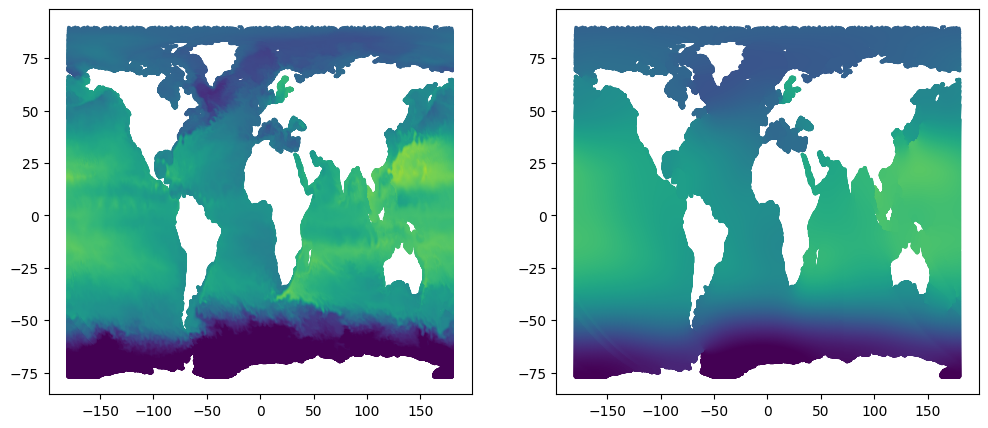

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(
    dsc.lon, dsc.lat, s=2, c=unfiltered, vmin=-1.5, vmax=1.5,
)

ax[1].scatter(
    dsc.lon, dsc.lat, s=2, c=filtered, vmin=-1.5, vmax=1.5,
)